<a href="https://colab.research.google.com/github/sds695/GovToronto/blob/main/data_analyst%26integrator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analyst and Integrator Programming Assignment

I start by downloading all the required packages and the main data set for this assignment(parking tickets). I then begin addressing the prompts for each of the sections.

In [256]:
!pip install geopandas
import zipfile
import json
import fiona
import numpy as np
import os
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="example app")
import pandas as pd
import csv
import math
import seaborn as sns
sns.set_theme(style="whitegrid")
import sys
import geopandas as gpd
import shapely
from fiona.crs import from_epsg
import chardet

## Parking data download and wrangling

The first step is to download the parking data which is stored in multiple zip files that I have downloaded and transfered to the directory of the notebook

In [ ]:
#Extracting all the zip files in the directory
for i in os.listdir():
  if '.zip' in i:
    with zipfile.ZipFile(i, 'r') as zip_ref:
      zip_ref.extractall()

Reading the data I noticed that a few of the records had an extra comma and therefore were creating 
an issue when reading through pandas. Therefore I decided to skip the records with this error.

In [ ]:
# Reading all the csv files and loading it into a common dataframe
parking_tags_df = pd.DataFrame()
error_files = []
for i in os.listdir():
  if '.csv' in i:
    print(i)
    try:
      temp_df = pd.read_csv(i, engine='c',error_bad_lines=False)
      #Adding a column that mentions the file name just so we can easily refer back to the file if needed
      temp_df['filename'] = i
      parking_tags_df = pd.concat([parking_tags_df,
               temp_df],ignore_index=True,axis=0,sort=False)
    except:
      print("There was an error in reading "+i)
      error_files.append(i)

Parking_Tags_Data_2015_3.csv
Parking_Tags_data_2009.csv


b'Skipping line 170864: expected 11 fields, saw 12\n'


Parking_Tags_Data_2014_1.csv
Parking_Tags_Data_2016_4.csv
Parking_Tags_Data_2015_2.csv
Parking_Tags_Data_2013.csv
There was an error in reading Parking_Tags_Data_2013.csv
Parking_Tags_Data_2015_1.csv
Parking_Tags_Data_2014_3.csv
Parking_Tags_data_2010.csv
There was an error in reading Parking_Tags_data_2010.csv
Parking_Tags_Data_2012.csv
Parking_Tags_Data_2014_4.csv
Parking_Tags_Data_2017_1.csv
Parking_Tags_data_2011.csv
Parking_Tags_Data_2018_3.csv
Parking_Tags_Data_2017_2.csv
Parking_Tags_Data_2014_2.csv
Parking_Tags_Data_2017_3.csv
Parking_Tags_Data_2018_2.csv
Parking_Tags_Data_2018_1.csv
Parking_Tags_Data_2016_2.csv
Parking_Tags_data_2008.csv
There was an error in reading Parking_Tags_data_2008.csv
Parking_Tags_Data_2016_3.csv
Parking_Tags_Data_2016_1.csv


In [ ]:
error_files

['Parking_Tags_Data_2013.csv',
 'Parking_Tags_data_2010.csv',
 'Parking_Tags_data_2008.csv']

In [ ]:
# Since there were three files which I had trouble in reading I will debug each and add them to the combined data frame

In [ ]:
parking_tags_df = parking_tags_df.append(pd.read_csv('Parking_Tags_Data_2013.csv',engine='python',error_bad_lines=False))

Skipping line 2351360: field larger than field limit (131072)


The 2010 Parking data had a different encoding for the file so we use chardet to detect the encoding.

In [ ]:
with open('Parking_Tags_data_2010.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 1.0, 'encoding': 'UTF-16', 'language': ''}

In [ ]:
parking_tags_df = parking_tags_df.append(pd.read_csv('Parking_Tags_data_2010.csv',encoding='UTF-16',error_bad_lines=False))

b'Skipping line 1075521: expected 11 fields, saw 14\n'
b'Skipping line 1413505: expected 11 fields, saw 16\n'


We check the encoding of the 2008 parking data as well and read the csv using the detected encoding

In [ ]:
with open('Parking_Tags_data_2008.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 1.0, 'encoding': 'UTF-16', 'language': ''}

In [ ]:
parking_tags_df = parking_tags_df.append(pd.read_csv('Parking_Tags_data_2008.csv',encoding='UTF-16',error_bad_lines=False))

b'Skipping line 181770: expected 11 fields, saw 12\n'


In [ ]:
parking_tags_df.shape

(27426589, 12)

## Section 3.1.1

In [ ]:
infraction_type_df = parking_tags_df[['infraction_code','infraction_description']].drop_duplicates(subset='infraction_code',keep='last')

In [ ]:
infraction_type_df.head()

,infraction_code,infraction_description
19062,411.0,PARK UNAUTH. VEH IN E-VEH. STN
247115,433.0,PARK NON-BUS IN BUS SPACE-METR
501450,436.0,PARK ELECT. VEH. EXCEED MAX TM
577746,166.0,PARK ON TRINITY DRIVE
2491431,139.0,PARK-PROH TIME ORIOLE ROAD


In [ ]:
parking_freq_df = parking_tags_df.groupby('infraction_code').count().reset_index()[['infraction_code','tag_number_masked']]

In [ ]:
parking_freq_df = parking_freq_df.merge(infraction_type_df,left_on='infraction_code',right_on='infraction_code')

In [ ]:
parking_freq_df = parking_freq_df.rename(columns={'tag_number_masked':'count_of_infractions'})

The top 20 infractions by frequency are as follows

---



In [ ]:
parking_freq_df.sort_values(by='count_of_infractions',ascending=False).head(20)

,infraction_code,count_of_infractions,infraction_description
4,5.0,5347742,PARK-HWY DRNG PROH TIMES/DAYS
27,29.0,4306826,PARK PROHIBITED TIME NO PERMIT
2,3.0,3728066,PARK/LEAVE ON PRIVATE PROPERTY
132,210.0,2792373,PARK FAIL TO DISPLAY RECEIPT
129,207.0,2251445,PARK FAIL TO DEP. FEE MACHINE
8,9.0,1605315,STOP HWY PROHIBITED TIME/DAY
1,2.0,1294077,PARK OVER 3 HOURS
7,8.0,1045142,STAND VEH-HWY-PROH TIME/DAYS
5,6.0,885722,PARK-HWY EXCESS PERMTD TIME
14,15.0,414519,PARK 3 M OF FIRE HYDRANT


## Section 3.1.2

In [ ]:
parking_fines_df = parking_tags_df.groupby('infraction_code').sum().reset_index()[['infraction_code','set_fine_amount']]

In [ ]:
parking_fines_df = parking_fines_df.merge(infraction_type_df,left_on='infraction_code',right_on='infraction_code')

In [ ]:
parking_fines_df = parking_fines_df.rename(columns={'set_fine_amount':'sum_of_fines'})

The top 20 infractions by revenue are as follows

In [ ]:
parking_fines_df.sort_values(by='sum_of_fines',ascending=False).head(20)

,infraction_code,sum_of_fines,infraction_description
4,5.0,220752490,PARK-HWY DRNG PROH TIMES/DAYS
27,29.0,129197850,PARK PROHIBITED TIME NO PERMIT
2,3.0,111839535,PARK/LEAVE ON PRIVATE PROPERTY
8,9.0,96310440,STOP HWY PROHIBITED TIME/DAY
132,210.0,83771190,PARK FAIL TO DISPLAY RECEIPT
129,207.0,67543350,PARK FAIL TO DEP. FEE MACHINE
7,8.0,62704920,STAND VEH-HWY-PROH TIME/DAYS
194,347.0,57796530,PARK IN A FIRE ROUTE
228,403.0,52327500,STOP-SIGNED HIGHWAY-RUSH HOUR
14,15.0,40679740,PARK 3 M OF FIRE HYDRANT


## Section 3.1.3

In [ ]:
print("The total revenue from tickets from 2008 to 2018 is " +
      str(parking_fines_df.sum(axis = 0, skipna = True)['sum_of_fines']))

The total revenue from tickets from 2008 to 2018 is 1183666805


## Section 3.1.4a

We need to import the 2019 green parking location dataset.

In [ ]:
f = open('green-p-parking-2019.json') 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 
green_parking_df = pd.DataFrame.from_dict(data['carparks'])

In [ ]:
top20_infractions = parking_tags_df.sort_values(by='set_fine_amount',ascending=False).head(20)

In [ ]:
top20_infractions['Latitude'] = 'Null'
top20_infractions['Longitude'] = 'Null'
for index,i in top20_infractions.iterrows():
  try:
    top20_infractions.loc[index,'Latitude'] = geolocator.geocode(i.loc["location2"]+",Toronto,Canada").point[0]
    top20_infractions.loc[index,'Longitude'] = geolocator.geocode(i.loc["location2"]+",Toronto,Canada").point[1]
  except AttributeError:
    continue
  except TypeError:
    continue

We define the function to calculate the distance between two points which will be used for the parking infractions.

In [ ]:
#Importing a function to calculate "As the crows fly" distance
def distance_on_unit_sphere(lat1, long1, lat2, long2):
    #src: http://www.johndcook.com/python_longitude_latitude.html
    degrees_to_radians = math.pi/180.0

    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
    return arc * 6373

In [ ]:
green_parking_df.head()

,id,slug,address,lat,lng,rate,carpark_type,carpark_type_str,is_ttc,is_under_construction,changing_rates,rate_half_hour,capacity,max_height,bike_racks,payment_methods,payment_options,rate_details,monthly_permit_status,monthly_permit_quantity,monthly_permit_price,map_marker_logo,alert_box,enable_streetview,streetview_lat,streetview_long,streetview_yaw,streetview_pitch,streetview_zoom
0,1,https://parking.greenp.com/carpark/1_20-charle...,20 Charles Street East,43.669282202140174,-79.3852894625656,$2.50 / Half Hour,garage,Garage,False,False,False,2.50,641,2.00,available,"[Bills, Coins, Charge (Visa / Mastercard / Ame...","[Auto Express Pay Stations, Credit Card at Ent...",{'periods': [{'title': 'Monday - Sunday & Holi...,not_available,,,greenp_only,Monthly Permits are no longer available at thi...,yes,43.669282202140174,-79.3852894625656,321.21,-12.45,0
1,3,https://parking.greenp.com/carpark/3_13-isabel...,13 Isabella Street,43.667577,-79.384707,$3.00 / Half Hour,surface,Surface,False,False,False,3.00,33,0.00,not available,"[Coins, Charge (Visa / Mastercard / American E...","[Pay and Display, Mobile Pay Available]",{'periods': [{'title': 'Monday - Sunday & Holi...,not_available,,,greenp_only,,yes,43.667735,-79.384966,115.84,7.51,0
2,5,https://parking.greenp.com/carpark/5_15-welles...,15 Wellesley Street East,43.664837,-79.383591,$3.00 / Half Hour,surface,Surface,False,False,False,3.00,135,0.00,available,"[Bills, Coins, Charge (Visa / Mastercard / Ame...","[Pay at Exit Lane Stations, Credit Card at Ent...",{'periods': [{'title': 'Monday - Sunday & Holi...,not_available,,,greenp_bikeshare,,yes,43.665083,-79.383807,138.09,-4.68,0
3,11,https://parking.greenp.com/carpark/11_21-pleas...,21 Pleasant Blvd.,43.687092,-79.392850,$3.00 / Half Hour,garage,Garage,False,False,False,3.00,557,1.90,available,"[Bills, Coins, Charge (Visa / Mastercard / Ame...","[Auto Express Pay Stations, Credit Card at Ent...",{'periods': [{'title': 'Monday - Sunday & Holi...,not_available,,180.00,greenp_only,,yes,43.686491,-79.392056,280.08,-13.18,0
4,12,https://parking.greenp.com/carpark/12_30-alvin...,30 Alvin Avenue,43.68919056469554,-79.39269983525526,$3.50 / Half Hour,surface,Surface,False,False,False,3.50,188,2.67,available,"[Bills, Coins, Charge (Visa / Mastercard / Ame...","[Pay at Exit Lane Stations, Credit Card at Ent...",{'periods': [{'title': 'Day Maximum until 6 PM...,not_available,,,greenp_only,,yes,43.68919056469554,-79.39269983525526,330.84,1.32,0


In [ ]:
top20_infractions['green_parking_distance(km)'] = 'Null'
for index1,i1 in top20_infractions.iterrows():
  min_dist = 1000000
  for index2,i2 in green_parking_df.iterrows():
    if distance_on_unit_sphere(float(i1['Latitude']), float(i1['Longitude'])
                               , float(i2['lat']), float(i2['lng']))<min_dist:
      min_dist = distance_on_unit_sphere(float(i1['Latitude']), float(i1['Longitude'])
                               , float(i2['lat']), float(i2['lng']))
  top20_infractions.loc[index1,'green_parking_distance(km)'] = min_dist

The field 'green_parking_distance' contains the distance of each of the infractions from the closest green parking location.

In [ ]:
top20_infractions.head()

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province,filename,Latitude,Longitude,green_parking_distance(km)
16868860,***21640,20180429,367.0,STND ONSTRT ACCESSIBLE NO PRMT,450,23.0,OPP,410 COLLEGE ST,NaN,NaN,ON,Parking_Tags_Data_2018_1.csv,43.657,-79.4064,0.407421
1814817,***82906,20080816,363.0,PARK ON-STRT DISABLD NO PERMIT,450,2028.0,NR,2161 QUEEN ST E,NaN,NaN,ON,NaN,43.6701,-79.2985,0.0619561
14841217,***22390,20170905,367.0,STND ONSTRT ACCESSIBLE NO PRMT,450,1027.0,NR,21 HILLCREST AVE,NaN,NaN,ON,Parking_Tags_Data_2017_3.csv,43.7674,-79.4112,0.245983
353791,***09053,20130223,355.0,PARK IN DISABLED NO PERMIT,450,1856.0,AT,2969 GRENVIEW BLVD S,NaN,NaN,ON,NaN,43.6477,-79.5078,0.115775
202489,***99380,20130131,367.0,STAND ON-ST DISABL LDG NO PRMT,450,1157.0,NR,18 GRENVILLE ST,NaN,NaN,ON,NaN,43.6619,-79.385,0.346248


## Section 3.1.4b

We need to import the TTC stops location dataset.

In [ ]:
ttc_stops = pd.read_csv('stops.txt')

In [ ]:
ttc_stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,262,662,DANFORTH RD AT KENNEDY RD,NaN,43.714379,-79.260939,NaN,NaN,NaN,NaN,NaN,2
1,263,929,DAVENPORT RD AT BEDFORD RD,NaN,43.674448,-79.399659,NaN,NaN,NaN,NaN,NaN,1
2,264,940,DAVENPORT RD AT DUPONT ST,NaN,43.675511,-79.401938,NaN,NaN,NaN,NaN,NaN,2
3,265,1871,DAVISVILLE AVE AT CLEVELAND ST,NaN,43.702088,-79.378112,NaN,NaN,NaN,NaN,NaN,1
4,266,11700,DISCO RD AT ATTWELL DR,NaN,43.701362,-79.594843,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
top20_infractions['ttc_stop_distance(km)'] = 'Null'
for index1,i1 in top20_infractions.iterrows():
  min_dist = 1000000
  for index2,i2 in ttc_stops.iterrows():
    if distance_on_unit_sphere(float(i1['Latitude']), float(i1['Longitude'])
                               , float(i2['stop_lat']), float(i2['stop_lon']))<min_dist:
      min_dist = distance_on_unit_sphere(float(i1['Latitude']), float(i1['Longitude'])
                               , float(i2['stop_lat']), float(i2['stop_lon']))
  top20_infractions.loc[index1,'ttc_stop_distance(km)'] = min_dist

The field 'ttc_stop_distance(km)' contains the distance of each of the infractions from the closest green parking location.



In [ ]:
top20_infractions.head()

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province,filename,Latitude,Longitude,green_parking_distance(km),ttc_stop_distance(km)
16868860,***21640,20180429,367.0,STND ONSTRT ACCESSIBLE NO PRMT,450,23.0,OPP,410 COLLEGE ST,NaN,NaN,ON,Parking_Tags_Data_2018_1.csv,43.657,-79.4064,0.407421,0.0901359
1814817,***82906,20080816,363.0,PARK ON-STRT DISABLD NO PERMIT,450,2028.0,NR,2161 QUEEN ST E,NaN,NaN,ON,NaN,43.6701,-79.2985,0.0619561,0.0996343
14841217,***22390,20170905,367.0,STND ONSTRT ACCESSIBLE NO PRMT,450,1027.0,NR,21 HILLCREST AVE,NaN,NaN,ON,Parking_Tags_Data_2017_3.csv,43.7674,-79.4112,0.245983,0.100517
353791,***09053,20130223,355.0,PARK IN DISABLED NO PERMIT,450,1856.0,AT,2969 GRENVIEW BLVD S,NaN,NaN,ON,NaN,43.6477,-79.5078,0.115775,0.0387476
202489,***99380,20130131,367.0,STAND ON-ST DISABL LDG NO PRMT,450,1157.0,NR,18 GRENVILLE ST,NaN,NaN,ON,NaN,43.6619,-79.385,0.346248,0.113465


We extract the fields from 'date_of_infraction' which we then aggregate for the upcoming sections.

In [ ]:
parking_tags_daily_df = parking_tags_df.groupby('date_of_infraction').count().reset_index()

In [ ]:
parking_tags_daily_df['year'] = parking_tags_daily_df['date_of_infraction'].apply(lambda x: str(x)[:4])
parking_tags_daily_df['month'] = parking_tags_daily_df['date_of_infraction'].apply(lambda x: str(x)[4:6])
parking_tags_daily_df['day'] = parking_tags_daily_df['date_of_infraction'].apply(lambda x: str(x)[6:])

In [ ]:

parking_tags_daily_df['date'] = parking_tags_daily_df['year'] + '-' + parking_tags_daily_df['month'] + '-'  + parking_tags_daily_df['day'] 
parking_tags_daily_df['date'] = parking_tags_daily_df['date'].astype('datetime64[ns]')
parking_tags_daily_df['weekday'] = parking_tags_daily_df['date'].dt.dayofweek

## Section 3.1.5a

In [ ]:
day_dictionary = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 
                  3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}

In [ ]:
parking_tags_daily_df['day_of_the_week'] = parking_tags_daily_df['weekday'].apply(lambda x:day_dictionary[x])

In [ ]:
parking_tags_daily_df.groupby('day_of_the_week').sum().reset_index()[['day_of_the_week','tag_number_masked']]\
.rename(columns={'tag_number_masked':'count_of_infractions'})

,day_of_the_week,count_of_infractions
0,Friday,4261925
1,Monday,3763037
2,Saturday,3737988
3,Sunday,2897095
4,Thursday,4258112
5,Tuesday,4258121
6,Wednesday,4250311


## Section 3.1.5b

In [ ]:
parking_tags_daily_df.groupby('month').sum().reset_index()[['month','tag_number_masked']]\
.rename(columns={'tag_number_masked':'count_of_infractions'})

,month,count_of_infractions
0,01,2178790
1,02,1937949
2,03,2482780
3,04,2383277
4,05,2419152
5,06,2383460
6,07,2297272
7,08,2304302
8,09,2295007
9,10,2382692


## Section 3.1.5c

Since I live in New Jersey for this section I had to research online to understand the seasons in Toronto([source](https://www.tripsavvy.com/weather-climate-seasons-guide-toronto-canada-4176215#:~:text=Toronto%20has%20four%20distinct%20seasons,Chicago%2C%20or%20New%20York%20City.))

I built the following dictionary to map months to seasons

In [ ]:
season_dict = {"06": "Summer", "07": "Summer", "08": "Summer",
               "09": "Fall", "10": "Fall", "11": "Fall",
               "12": "Winter", "01": "Winter", "02": "Winter",
               "03": "Spring", "04": "Spring", "05": "Spring"}

In [ ]:
parking_tags_daily_df['season'] = parking_tags_daily_df['month'].apply(lambda x:season_dict[x])

In [ ]:
parking_tags_daily_df.groupby('season').sum().reset_index()[['season','tag_number_masked']]\
.rename(columns={'tag_number_masked':'count_of_infractions'})

,season,count_of_infractions
0,Fall,6989685
1,Spring,7285209
2,Summer,6985034
3,Winter,6166661


## Section 3.3.1.a.i

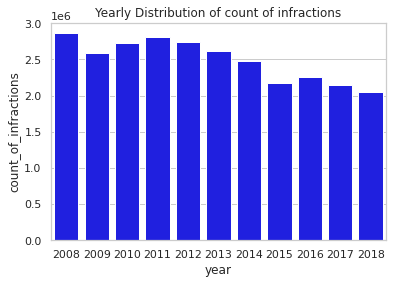

In [213]:
ax = sns.barplot(x="year", y="count_of_infractions",
                 data=parking_tags_daily_df.groupby('year').sum().reset_index()\
                 .rename(columns={'tag_number_masked':'count_of_infractions'}),
                 color='blue').set_title("Yearly Distribution of count of infractions")

## Section 3.3.1.a.ii

In [215]:
parking_tags_df.head()

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province,filename
0,***98714,20150911,210.0,PARK FAIL TO DISPLAY RECEIPT,30,1707.0,NR,151 DAN LECKIE WAY,NaN,NaN,ON,Parking_Tags_Data_2015_3.csv
1,***03276,20150911,403.0,STOP-SIGNED HIGHWAY-RUSH HOUR,150,1707.0,NR,2143 DANFORTH AVE,NaN,NaN,ON,Parking_Tags_Data_2015_3.csv
2,***06931,20150911,2.0,PARK - LONGER THAN 3 HOURS,15,1707.0,NR,90 BURNSIDE DR,NaN,NaN,ON,Parking_Tags_Data_2015_3.csv
3,***78878,20150911,29.0,PARK PROHIBITED TIME NO PERMIT,30,1707.0,NR,41 DALTON RD,NaN,NaN,ON,Parking_Tags_Data_2015_3.csv
4,***01730,20150911,210.0,PARK FAIL TO DISPLAY RECEIPT,30,1707.0,NR,10 ELLERBECK ST,NaN,NaN,ON,Parking_Tags_Data_2015_3.csv


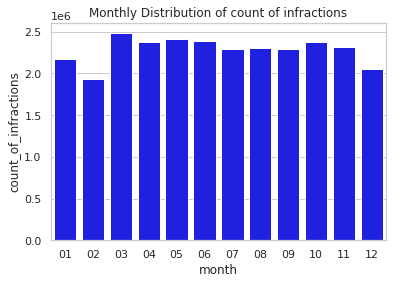

In [216]:
ax = sns.barplot(x="month", y="count_of_infractions",
                 data=parking_tags_daily_df.groupby('month').sum().reset_index()\
                 .rename(columns={'tag_number_masked':'count_of_infractions'}),
                 color='blue').set_title("Monthly Distribution of count of infractions")

## Section 3.3.1.b

In [ ]:
top20_freq = parking_freq_df.sort_values(by='count_of_infractions',ascending=False).head(20)
top20_freq['infraction_code'] = top20_freq['infraction_code'].apply(lambda x:int(x))

[Text(0, 0, '5'),
 Text(0, 0, '29'),
 Text(0, 0, '3'),
 Text(0, 0, '210'),
 Text(0, 0, '207'),
 Text(0, 0, '9'),
 Text(0, 0, '2'),
 Text(0, 0, '8'),
 Text(0, 0, '6'),
 Text(0, 0, '15'),
 Text(0, 0, '406'),
 Text(0, 0, '403'),
 Text(0, 0, '28'),
 Text(0, 0, '30'),
 Text(0, 0, '192'),
 Text(0, 0, '312'),
 Text(0, 0, '347'),
 Text(0, 0, '134'),
 Text(0, 0, '16'),
 Text(0, 0, '337')]

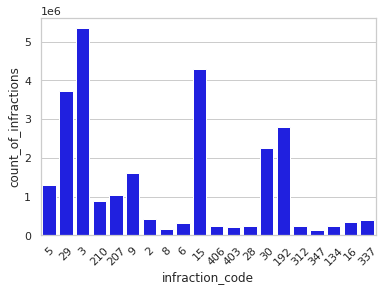

In [ ]:
ax = sns.barplot(x="infraction_code", y="count_of_infractions",
                 data=top20_freq,
                 color='blue')
ax.set_xticklabels(rotation=45,labels=top20_freq['infraction_code'])


## Section 3.3.2.a

In [139]:
top20_infractions['lonlat']=list(zip(top20_infractions['Longitude'],top20_infractions['Latitude']))
top20_infractions['geometry']=top20_infractions[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [140]:
top20_infractions = gpd.GeoDataFrame(top20_infractions)
top20_infractions.crs = from_epsg(4326)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [151]:
top20_infractions.to_csv("top20_infractions_freq.csv")

In [119]:
city_wards_df =  gpd.GeoDataFrame.from_file('City Wards Data.geojson')

We plot the top 20 infractions by frequency with the city wards shapefile as the base layer to see the distribution of points.

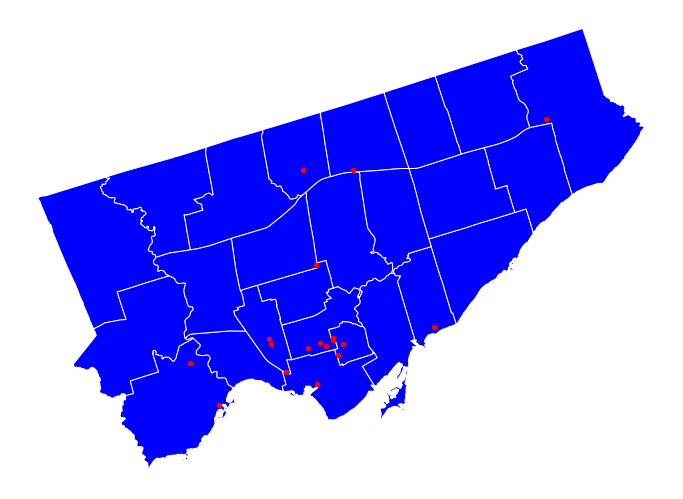

In [120]:
base =city_wards_df.plot(color='blue',figsize=(12,12))
base.axis('off')
top20_infractions.plot(ax=base, marker='o',color='red', markersize=20)

## Section 3.3.2.b

Here I used QGIS to perform the spatial join and find out which city ward each of the infractions lie in. Below I have attached the screenshot of the QGIS screen where I performed the join.

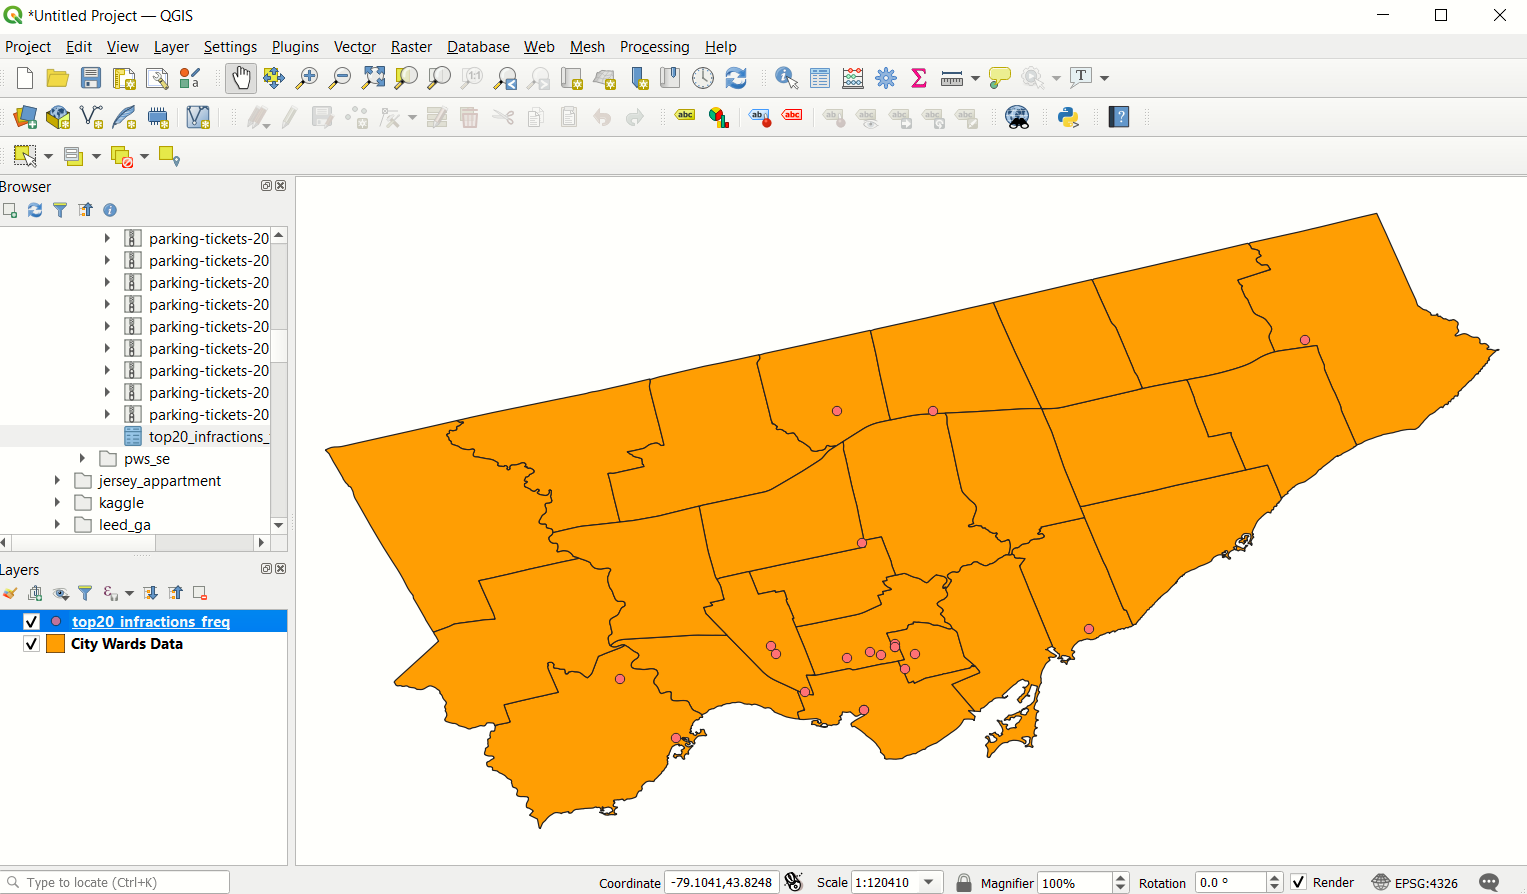

In [217]:
# Reading the file after the QGIS spatial join.
top20_infractions_city_ward_df = pd.read_csv('top20_infractions_city_ward.csv')

In [176]:
top20_infractions_city_ward_df = top20_infractions_city_ward_df.groupby('_id')\
.count().reset_index()[['_id','tag_number']].rename(columns={'tag_number':'count_per_ward'})

(-513762.50691669586,
 -360548.8632211285,
 1286397.3377522372,
 1389742.3015592822)

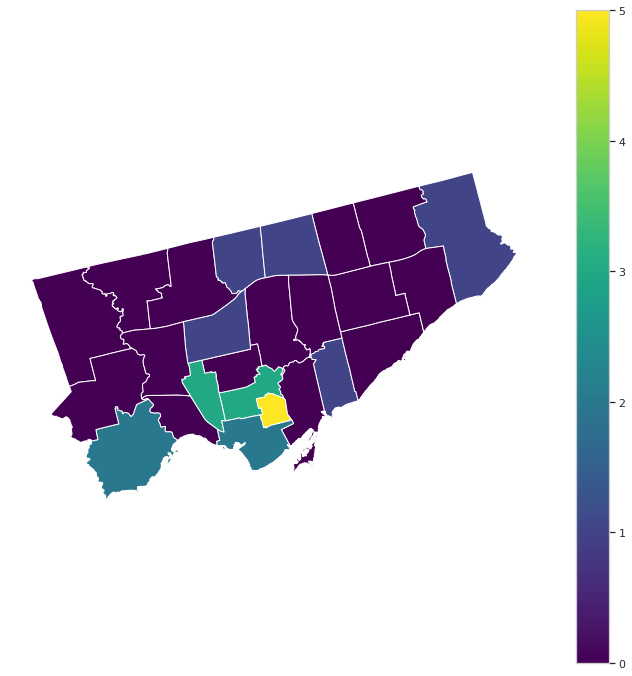

In [187]:
base = city_wards_df.merge(top20_infractions_city_ward_df,on='_id',how='left').fillna(0)\
.plot(figsize=(12,12),cmap='viridis',column='count_per_ward',legend=True)
base.axis('off')

## Section 3.3.2.c

Similar to the previous section the spatial join was done using QGIS and the file imported back.

In [200]:
top20_revenue_infractions = parking_tags_df.sort_values(by='set_fine_amount',ascending=False).head(20)

In [201]:
top20_revenue_infractions['Latitude'] = 'Null'
top20_revenue_infractions['Longitude'] = 'Null'
for index,i in top20_revenue_infractions.iterrows():
  try:
    top20_revenue_infractions.loc[index,'Latitude'] = geolocator.geocode(i.loc["location2"]+",Toronto,Canada").point[0]
    top20_revenue_infractions.loc[index,'Longitude'] = geolocator.geocode(i.loc["location2"]+",Toronto,Canada").point[1]
  except AttributeError:
    continue
  except TypeError:
    continue

In [202]:
top20_revenue_infractions.to_csv('top20_infractions_revenue.csv')

In [203]:
# Reading the file after the QGIS spatial join.
top20_infractions_revenue_city_ward_df = pd.read_csv('top20_infractions_revenue_city_ward.csv')

In [204]:
top20_infractions_revenue_city_ward_df.head()

,field_1,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province,filename,Latitude,Longitude,_id,AREA_ID,DATE_EFFECTIVE,DATE_EXPIRY,AREA_ATTR_ID,AREA_TYPE_ID,PARENT_AREA_ID,AREA_TYPE,AREA_CLASS_ID,AREA_CLASS,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,FEATURE_CODE,FEATURE_CODE_DESC,TRANS_ID_CREATE,TRANS_ID_EXPIRE,X,Y,LONGITUDE_2,LATITUDE_2,OBJECTID,Shape__Area,Shape__Length
0,16868860,***21640,20180429,367,STND ONSTRT ACCESSIBLE NO PRMT,450,23,OPP,410 COLLEGE ST,NaN,NaN,ON,Parking_Tags_Data_2018_1.csv,43.657025,-79.406371,2004,2457737,2018/08/07 18:11:06,3000/01/01 05:00:00,25993193,528,NaN,CITW,NaN,NaN,11,11,University-Rosedale,University-Rosedale (11),NaN,NaN,279754,-1,NaN,NaN,NaN,NaN,17344833,2.600299e+07,29861.631464
1,1814817,***82906,20080816,363,PARK ON-STRT DISABLD NO PERMIT,450,2028,NR,2161 QUEEN ST E,NaN,NaN,ON,NaN,43.670071,-79.298509,2005,2457736,2018/08/07 18:11:06,3000/01/01 05:00:00,25993192,528,NaN,CITW,NaN,NaN,19,19,Beaches-East York,Beaches-East York (19),NaN,NaN,279754,-1,NaN,NaN,NaN,NaN,17344849,3.215503e+07,30975.878034
2,14841217,***22390,20170905,367,STND ONSTRT ACCESSIBLE NO PRMT,450,1027,NR,21 HILLCREST AVE,NaN,NaN,ON,Parking_Tags_Data_2017_3.csv,43.767436,-79.411247,2003,2457738,2018/08/07 18:11:06,3000/01/01 05:00:00,25993194,528,NaN,CITW,NaN,NaN,18,18,Willowdale,Willowdale (18),NaN,NaN,279754,-1,NaN,NaN,NaN,NaN,17344817,3.792649e+07,24766.996984
3,353791,***09053,20130223,355,PARK IN DISABLED NO PERMIT,450,1856,AT,2969 GRENVIEW BLVD S,NaN,NaN,ON,NaN,43.647697,-79.507821,2016,2457725,2018/08/07 18:11:06,3000/01/01 05:00:00,25993181,528,NaN,CITW,NaN,NaN,3,3,Etobicoke-Lakeshore,Etobicoke-Lakeshore (3),NaN,NaN,279754,-1,NaN,NaN,NaN,NaN,17345025,7.641257e+07,60137.672264
4,202489,***99380,20130131,367,STAND ON-ST DISABL LDG NO PRMT,450,1157,NR,18 GRENVILLE ST,NaN,NaN,ON,NaN,43.661889,-79.384973,2022,2457719,2018/08/07 18:11:06,3000/01/01 05:00:00,25993175,528,NaN,CITW,NaN,NaN,13,13,Toronto Centre,Toronto Centre (13),NaN,NaN,279754,-1,NaN,NaN,NaN,NaN,17345121,1.120816e+07,14958.064680


In [205]:
top20_infractions_revenue_city_ward_df = top20_infractions_revenue_city_ward_df.groupby('_id')\
.sum().reset_index()[['_id','set_fine_amount']].rename(columns={'set_fine_amount':'sum_revenue'})

In [206]:
top20_infractions_revenue_city_ward_df

,_id,sum_revenue
0,2003,450
1,2004,1350
2,2005,450
3,2007,450
4,2016,900
5,2018,450
6,2019,450
7,2021,1350
8,2022,2250
9,2025,900


(-513762.50691669586,
 -360548.8632211285,
 1286397.3377522372,
 1389742.3015592822)

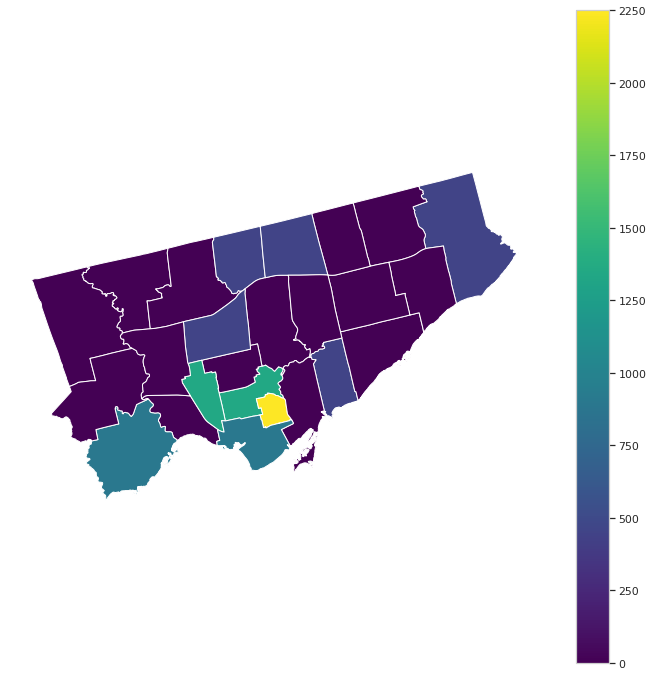

In [207]:
base = city_wards_df.merge(top20_infractions_revenue_city_ward_df,on='_id',how='left').fillna(0)\
.plot(figsize=(12,12),cmap='viridis',column='sum_revenue',legend=True)
base.axis('off')

## Section 3.3.2.d

For this operation I downloaded the Neighborhood Crimes rate geojson to plot the data in the demographics file.

In [220]:
demographic_data = pd.read_excel('demographics-nhs-indicators-2011.xlsx')

In [230]:
neighborhoods_gdf.head()

,_id,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,Assault_CHG,Assault_Rate_2019,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,AutoTheft_AVG,AutoTheft_CHG,AutoTheft_Rate_2019,BreakandEnter_2014,BreakandEnter_2015,BreakandEnter_2016,BreakandEnter_2017,BreakandEnter_2018,BreakandEnter_2019,BreakandEnter_AVG,BreakandEnter_CHG,BreakandEnter_Rate_2019,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Homicide_AVG,Homicide_CHG,Homicide_Rate_2019,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,Robbery_AVG,Robbery_CHG,Robbery_Rate_2019,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length,geometry
0,1,16,South Parkdale,85,21849,202,226,231,229,220,251,226.5,0.14,1148.8,13,20,23,19,17,20,18.7,0.18,91.5,45,51,71,58,78,89,65.3,0.14,407.3,0,0,1,0,0,1,0.3,1.0,4.6,24,35,41,30,35,33,33.0,-0.06,151.0,6,4,9,10,9,22,10.0,1.44,100.7,2.286974e+06,10802.832160,"POLYGON ((-79.42774 43.62979, -79.42944 43.630..."
1,2,17,South Riverdale,70,27876,215,207,236,243,304,261,244.3,-0.14,936.3,18,23,27,37,40,40,30.8,0.00,143.5,89,98,148,94,91,133,108.8,0.46,477.1,1,0,3,5,2,0,1.8,-1.0,0.0,64,42,49,64,40,35,49.0,-0.13,125.6,18,16,22,27,24,21,21.3,-0.13,75.3,1.096457e+07,43080.724701,"POLYGON ((-79.32864 43.64745, -79.32863 43.647..."
2,3,18,St.Andrew-Windfields,40,17812,53,41,48,45,55,58,50.0,0.05,325.6,15,25,10,15,21,35,20.2,0.67,196.5,81,79,57,91,81,83,78.7,0.02,466.0,1,0,0,2,0,0,0.5,0.0,0.0,8,5,14,0,4,12,7.2,2.00,67.4,10,14,8,7,6,6,8.5,0.00,33.7,7.299580e+06,13025.997456,"POLYGON ((-79.34386 43.75650, -79.34700 43.755..."
3,4,19,Taylor-Massey,61,15683,127,92,97,107,123,122,111.3,-0.01,777.9,11,9,7,5,12,12,9.3,0.00,76.5,31,71,43,27,41,63,46.0,0.54,401.7,0,1,1,1,0,1,0.7,1.0,6.4,24,37,16,20,16,13,21.0,-0.19,82.9,4,3,5,2,4,3,3.5,-0.25,19.1,1.062970e+06,5940.700050,"POLYGON ((-79.28772 43.68978, -79.29265 43.688..."
4,5,20,Humber Summit,21,12416,76,89,118,116,109,118,104.3,0.08,950.4,66,42,62,83,106,135,82.3,0.27,1087.3,54,44,41,40,56,57,48.7,0.02,459.1,0,1,0,2,1,3,1.2,2.0,24.2,22,23,23,27,31,28,25.7,-0.10,225.5,15,16,18,18,15,22,17.3,0.47,177.2,7.966905e+06,12608.573118,"POLYGON ((-79.58060 43.76302, -79.57750 43.763..."


In [231]:
neighborhoods_gdf = gpd.GeoDataFrame.from_file('Neighbourhood Crime Rates.geojson')[['Hood_ID','geometry']]

In [233]:
neighborhoods_gdf = neighborhoods_gdf.merge(demographic_data,left_on='Hood_ID',right_on='Hood#')

In [241]:
#We import the infractions which has been spatially joined with the Neighborhood shapefile on QGIS
demographic_infractions = pd.read_csv('Demographic_shape_file.csv')\
.groupby('Hood_ID').count().reset_index()[['Hood_ID','tag_number_masked']]\
.rename(columns={'tag_number_masked':'count_of_infractions'})

In [265]:
demographic_left_gdf = neighborhoods_gdf.merge(demographic_infractions,on='Hood_ID',how='left').fillna(np.nan)
demographic_inner_gdf = neighborhoods_gdf.merge(demographic_infractions,on='Hood_ID',how='inner').fillna(np.nan)

In [262]:
demographic_gdf.head()

,Hood_ID,geometry,Hood#,Total Population,Child0-14,Youth15-24,Seniors65,Total visible minority population,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japanese,"Visible minority, n.i.e.",Multiple visible minorities,Not a visible minority,Total - Mobility status 5 years ago,Non-movers,Movers,Total recent immigrant population in private households by selected places of birth,Middle East/Western Asia,Eastern,South East,Southern,Other places of birth in Asia,Americas w/o USA,Europe,Africa,Total population aged 15 years and over by labour force status,In the labour force,Unemployed,Not in the labour force,"No certificate, diploma or degree","College, CEGEP or other non-university certificate or diploma",University certificate or diploma below bachelor level,Total number of private households by tenure,Owner,Renter,% of owner households spending 30% or more of household total income on shelter costs,Major repairs needed,Average monthly shelter costs for rented dwellings ($),Average after-tax family income $ (Family income in 2010 of economic families),Household income in 2010 of private households,Median household total income $,Median after-tax household income $,count_of_infractions
0,85,"POLYGON ((-79.42774 43.62979, -79.42944 43.630...",85,21245,2565,2410,2225,9700,1955,645,1750,1440,520,275,965,215,130,160,1260,390,10365,19000,7790,11210,3005,30,345,470,1300,60.0,115,320,210,17475,11555,1495,5920,3435,2870,750,10595,1105,9485,30.3,1025,865,54454,10595,35601,32539,NaN
1,70,"POLYGON ((-79.32864 43.64745, -79.32863 43.647...",70,25640,3435,2725,2780,11390,940,6635,1090,615,225,50,550,45,30,150,290,765,13380,23245,13220,10030,1185,0,675,55,55,0.0,30,100,60,21275,14790,1060,6485,4325,3040,940,10740,6635,4105,27.3,1115,859,83795,10745,65076,56192,NaN
2,40,"POLYGON ((-79.34386 43.75650, -79.34700 43.755...",40,17955,2725,2770,2680,7725,1080,3220,400,495,220,135,120,820,900,115,50,170,10165,17235,10455,6785,1590,340,650,55,135,0.0,130,185,30,15260,9610,810,5650,1435,1855,1045,6460,4290,2180,26.3,215,1270,162988,6460,94271,80145,NaN
3,61,"POLYGON ((-79.28772 43.68978, -79.29265 43.688...",61,15595,3030,1760,1600,9990,5670,830,1235,695,305,70,395,280,70,35,170,235,5405,14195,6595,7600,3165,230,170,165,1850,80.0,130,190,280,12355,7990,1295,4360,2145,1915,490,6295,2260,4035,36.6,790,882,51131,6295,40915,37875,NaN
4,21,"POLYGON ((-79.58060 43.76302, -79.57750 43.763...",21,12530,2305,1740,2265,7340,3980,65,1195,140,555,265,550,335,0,0,140,120,5165,11800,8170,3635,1055,180,0,30,590,0.0,140,0,40,10255,5800,645,4450,3745,1365,310,3790,2745,1045,29.2,155,907,65757,3790,57786,53272,NaN


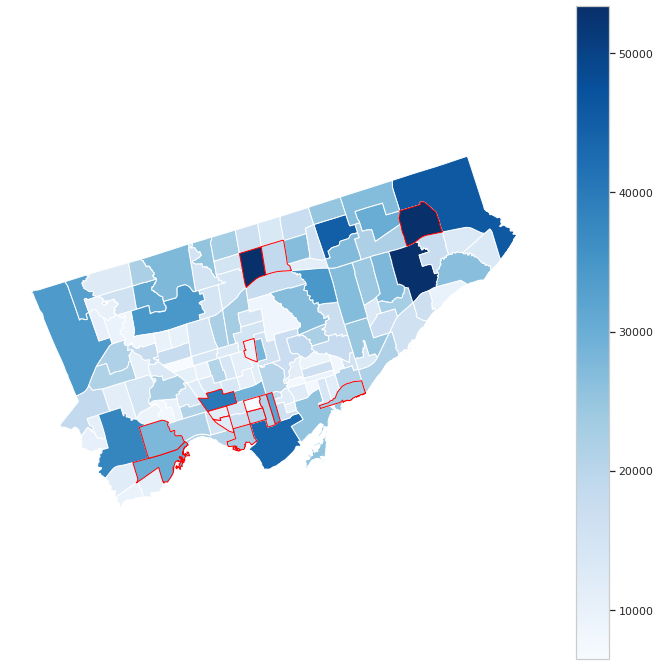

In [275]:
base = demographic_left_gdf.plot(column='Total Population',figsize=(12,12),cmap='Blues',legend=True)
base.axis('off')
demographic_inner_gdf.plot(ax=base,column='Total Population',edgecolor="red",cmap='Blues')

In the plot above we see the top 20 ticket infraction locations highlighted in red. Looking at the population in each neighborhood we cannot conclude anything as some have really high populations and some really low.

In [277]:
demographic_left_gdf.columns

Index(['Hood_ID', 'geometry', 'Hood#', 'Total Population', 'Child0-14',
       'Youth15-24', 'Seniors65', '  Total visible minority population',
       '    South Asian', '    Chinese', '    Black', '    Filipino',
       '    Latin American', '    Arab', '    Southeast Asian',
       '    West Asian', '    Korean', '    Japanese',
       '    Visible minority, n.i.e.', '    Multiple visible minorities',
       '  Not a visible minority', 'Total - Mobility status 5 years ago',
       '  Non-movers', '  Movers',
       'Total recent immigrant population in private households by selected places of birth',
       'Middle East/Western Asia', 'Eastern', 'South East', 'Southern',
       '    Other places of birth in Asia', 'Americas w/o USA', '  Europe',
       '  Africa',
       'Total population aged 15 years and over by labour force status ',
       '  In the labour force ', '    Unemployed', '  Not in the labour force',
       '  No certificate, diploma or degree',
       '    College, C

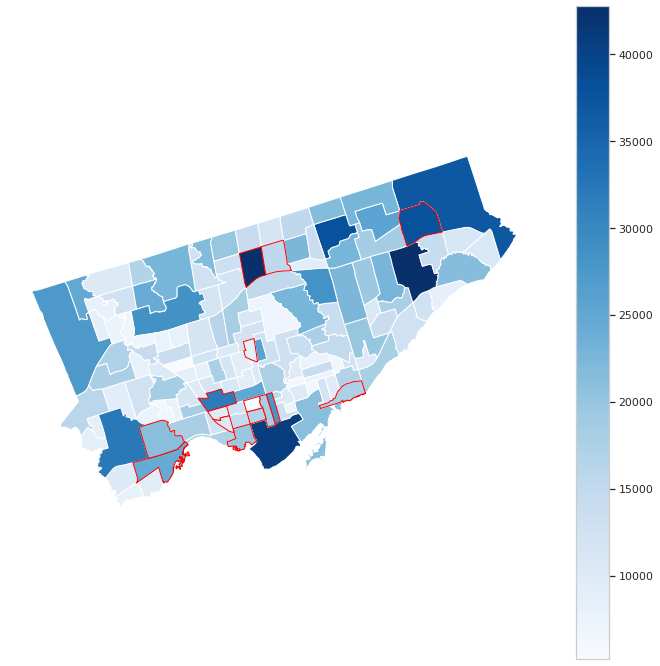

In [279]:
base = demographic_left_gdf.plot(column='Total population aged 15 years and over by labour force status ',figsize=(12,12),cmap='Blues',legend=True)
base.axis('off')
demographic_inner_gdf.plot(ax=base,column='Total population aged 15 years and over by labour force status ',edgecolor="red",cmap='Blues')

It does appear that most of the areas with infractions have medium to high number of population aged 15 years and over by labour force status. This could however be the case because there are just a lot more people in these neighborhoods as it looks very similar to the total population plot.

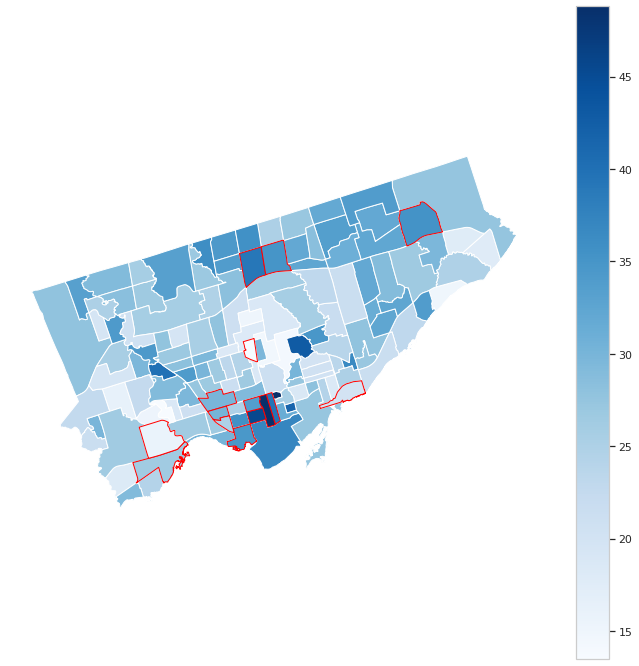

In [280]:
base = demographic_left_gdf.plot(column='  % of owner households spending 30% or more of household total income on shelter costs',figsize=(12,12),cmap='Blues',legend=True)
base.axis('off')
demographic_inner_gdf.plot(ax=base,column='  % of owner households spending 30% or more of household total income on shelter costs',edgecolor="red",cmap='Blues')

Interestingly the areas with higher percentage of the people paying more than 30% of their income seems to have a lot of the top infractions. 